## Imports and Needed functions

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Dec 6, 2023

@author: Jamiree Harrison
         https://github.com/Jamiree
         jamiree@ucsb.edu

Purpose of script: 
Simulates hybrid promoter data. 
Produces hybrid promoter model parameters that fit the simulated data. 
The assumed model is that of protein synthesis, we simply fit the parameters 
of this model at different time intervals. 

"""

import sys

# Imports
import numpy as np
from numpy import linalg as LA
import math
import matplotlib.pyplot as plt
import random
import ruptures as rpt
import statistics as stats
import string
from scipy.stats import sem
from scipy.signal import savgol_filter
from scipy.linalg import toeplitz
from mpl_toolkits import mplot3d
from random import gauss
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
from scipy.optimize import curve_fit
from scipy.optimize import minimize
from ruptures.metrics import hausdorff
import os


## Backend Functions

In [2]:
############################################################ 

''' Uses binary segmentation to detect when a signal switches
    
    Documentation: 
    https://centre-borelli.github.io/ruptures-docs/user-guide/detection/binseg/

'''
def bkpt_binseg(signal, model, sigma): 
    
    n = len(signal)
    
    # Point Detection:
    # here we choose the Least-squares estimate for changes in autoregressive (ar) coefficients
    algo = rpt.Binseg(model=model).fit(signal)
    
    # manually select how many breakpoints to select
    if type(sigma) == str:
        sigma = int(sigma)
        my_bkps = algo.predict(n_bkps=sigma)
        
        # show results
        # rpt.show.display(signal, my_bkps, figsize=(10, 6))
        # plt.show()
        
    else:
    
        ## if we want to treat the number of change points as unknown, use
        ## one of the following (note: sigma is the standard deviation of the noise. ) : 

        ## specify a penalty using the pen parameter
        # sigma = 0.1
        # dim = 1
        # my_bkps = algo.predict(pen=np.log(n) * sigma**2)

        ## specify a threshold on the residual norm using epsilon
        ## note that sigma needs to be small for non-noisy data
        my_bkps = algo.predict(epsilon = n * sigma**2)

        # show results
        # rpt.show.display(signal, my_bkps, figsize=(10, 6))
        # plt.show()

    return my_bkps


############################################################ 

''' Detects the times that a signal "switches"

inputs:  data                            | array of size (num_time_pts, num_states)
             - each column of the data array is the evolution of that state in time
         t                               | array of size (num_time_pts, 1)
             - time vector
             
         switch_gap                      | integer
             - must define the number of indices that is allowable
                between switches.  If switch_gap is zero, then you 
                cannot have consecutive time points being switch times
        
         ls_model                           | str
            - pick from the following least-squares estimates:
                "l1", "l2", "rbf", "linear", "normal", "ar",...
        
         \\sigma   (type determined)     | float 
                                 | (if the number of switches is
                                 | to be determined by algorithm)
            - standard deviation of the noise in the data
         \\sigma   (type determined)     | str 
                                | (if the number of switches is
                                | to be input by the user)
            - standard deviation of the noise in the data
                
outputs: t_switch_index         | array of size (num_switches, 0) 
         num_switches           | integer
         num_time_intervals     | integer
         time_of_switch         | array of size (num_switches, 0) 
'''
def switch_time_detect(data, t, switch_gap, ls_model, sigma):
    
    num_time_pts, num_states = np.shape(data)
    
    true_t_switch_index = np.array([], dtype=int)
    
    # iterate over all states of system
    for j in range(num_states):
        
        # detects switch time using binary segmentation 
        t_switch_index = bkpt_binseg(data[:,j], ls_model, sigma)

        # the following code removes switch indices that are too close for each state
        result = [t_switch_index[0]]
        for i in range(1, len(t_switch_index)):
            # makes it so that consecutive switches are not too close
            if t_switch_index[i] > t_switch_index[i - 1] + switch_gap:
                # Remove the current indexed entry
                result = np.append(result, t_switch_index[i])

        # makes it so that the last time point cannot be a switch time
        if result[-1] == len(t):
            result = np.delete(result, -1)
            
        
        # indices of t where state switching occurs in the j-th state
        t_switch_index = result 
        
        # print('switches = ',t_switch_index)
        
        # only takes switches not already detected from previous states
        for entry in t_switch_index:
            if entry not in true_t_switch_index:
                true_t_switch_index = np.append(true_t_switch_index, entry)
        true_t_switch_index = np.sort(true_t_switch_index)

        # print('time indices of switches: ', true_t_switch_index)
        
    # checks if there are no switches
    if len(true_t_switch_index) == 0:

        num_switches = 0
        time_of_switch = np.zeros((num_switches,))
        num_time_intervals = num_switches + 1
        print('no switches detected in signal given chosen parameters')
        
        return true_t_switch_index, num_switches, num_time_intervals, time_of_switch
            
    else:
        result = [true_t_switch_index[0]]
        for i in range(1, len(true_t_switch_index)):
            # makes it so that consecutive switches are not too close
            if true_t_switch_index[i] > true_t_switch_index[i - 1] + switch_gap:
                # Remove the current indexed entry
                result = np.append(result, true_t_switch_index[i])
                
        # makes it so that the last time point cannot be a switch time            
        if result[-1] == len(t):
            result = np.delete(result, -1)

        true_t_switch_index = result
               
    num_switches = len(true_t_switch_index)
    
    if isinstance(sigma, str) and int(sigma) != num_switches:
        print('expected switch number not equal to detected number of switches')


    # gets times of switches
    time_of_switch = np.zeros((num_switches,))
    for i in range(num_switches):
        time_of_switch[i] = t[true_t_switch_index[i]]

    print('times_of_switches = ', time_of_switch)

    
    # plt.figure()
    # plt.plot(t, data[:,num_states//2], 'g', label='x(t)')
    # plt.plot(t[true_t_switch_index], data[true_t_switch_index, num_states//2], 'ro')
    # plt.xlabel('time')
    # plt.ylabel('cross section of u(t,x) for some x')
    # plt.title('switch times found')
    # plt.savefig(os.path.join(os.getcwd(), 'switch times.svg'), format='svg')
    # plt.show()
        
    num_time_intervals = num_switches + 1
    
#     print('num_switches =', num_switches)
#     print('num_time_intervals =', num_time_intervals)
    
    return true_t_switch_index, num_switches, num_time_intervals, time_of_switch

    
############################################################ 

''' Breaks data up into sections based on the 
    times of the switches

inputs:  data                   | array of size (num_time_pts, num_states)
             - each column of the data array is the evolution of that state in time
             
         t                      | array of size (num_time_pts, 1)
             - time vector
        
         num_switches           | integer
        
         t_switch_index         | array of size (num_switches, 0) 
                     
outputs: data_intervals_dict    | dictionary of data over time intervals
            - example: data_intervals_dict['data_t0']
                       gives the data over the first time interval
                       
         time_intervals_dict    | dictionary of time intervals
            - example: time_intervals_dict['t0']
                       gives the first time interval
'''
def data_segementation(data, t, num_switches, t_switch_index):
    
    # instantiate dictionary of data over the time intervals
    data_intervals_dict = {}

    # instantiate dictionary of the time intervals
    time_intervals_dict = {}

    # used to iterate through every time point
    temp_index = 0  

    # iterates through time up to the last switch time
    for i in range(num_switches):
        
        key = f"t{i}"
        
        # data over the i-th time interval
        data_intervals_dict[key] = data[temp_index:t_switch_index[i] , :]

        # the i-th time interval
        time_intervals_dict[key] = t[temp_index:t_switch_index[i]]

        # updtate the index of the current time point
        temp_index = t_switch_index[i]

    # data over the last time interval
    key = f"t{num_switches}"
    data_intervals_dict[key] = data[temp_index: , :]

    # last time interval
    time_intervals_dict[key] = t[temp_index:]
    
    return data_intervals_dict, time_intervals_dict

############################################################ 

''' Fits the params of the model over each time interval

inputs:  data_intervals_dict    | dictionary of semented data
             
         time_intervals_dict    | dictionary of semented time vector
             - time vector
        
         dt                     | float
             - sampling time, i.e. difference between time points
             
         params_init            | array of size (num_model_params, )
         bounds                 | see documentation for scipy optimize
          https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html
         
         num_time_intervals.    | float
                     
outputs: params_dict            | dictionary of parameter values over 
                                | each time interval

         param_matrix           | array of size (num_model_params, num_time_intervals)
         param_time             | dictionary of parameter values for each point in time

'''
def fit_params(data_intervals_dict, time_intervals_dict, dt, params_init, bounds, 
               num_time_intervals, num_static_params):
    
    num_model_params = len(params_init)
    
    # matrix of params
    param_matrix = np.zeros((num_model_params, num_time_intervals))

    # dictionary of params
    params_dict = {}

    for i in range(num_time_intervals):

        # Minimize the objective function over each time domain

        key = f"t{i}"
        
        result = minimize(objective, 
                         params_init, 
                         args=(data_intervals_dict[key], 
                               dt, time_intervals_dict[key]), 
                         method='Nelder-Mead', 
                         bounds = bounds)
        
        params_approx = result.x

        params_dict[key] = params_approx
        param_matrix[:,i] = params_approx

        # Print the estimated parameters
        # print("Estimated parameters for the " + str(i+1)  +"th time interval:")

        # Sets initial parameter value guesses for next time interval
        # Note that we use the results from the first time domain fit as our new
        # initial guesses
        params_init = result.x
        
        if i == 0: 
            # first set of params found over first time interval
            first_params = result.x
            
            num_vary_params = num_model_params - num_static_params
            
            # if no bounds are selected for the params, then make it so that
            # the time-varying params are able to vary, while the static
            # params must stay the same.
            if bounds == None:
                bounds = []
                # set bounds for params in the form of : (lower, upper)
                for j in range(num_vary_params):
                    bounds.append((-np.inf , np.inf)) 
                
                # makes it so that the static params do not change
                for j in range(num_static_params):
                    bounds.append((first_params[j + num_vary_params], first_params[j + num_vary_params]))
                    
            else: 
                
                # if bounds are selected for the params, then make it so that
                # the time-varying params are able to vary within the pre-set bounds
                # while the static params must stay the same.
                bounds = bounds[:num_vary_params]     # keeps initialized bounds
                for j in range(num_static_params):
                    # makes it so that the static params do not change
                    bounds.append((first_params[j + num_vary_params], first_params[j + num_vary_params]))
                
            print('bounds=',bounds)

    # dictionary containing arrays of each parameter at each time point
    param_time = {}

    for k in range(num_model_params):

        # initialize array
        param_time[f"p{k}"] = []
        for i in range(num_time_intervals):

            # iterates through time intervals and stitches together the parameter arrays
            param_time[f"p{k}"] = np.append(param_time[f"p{k}"] , 
                                   param_matrix[k,i]*np.ones(len(time_intervals_dict[f't{i}'])))
        
    return params_dict, param_matrix, param_time

############################################################ 

''' Generate approx trajectory using estimated params

inputs:  params_dict            | dictionary of parameters for each time interval

         data_intervals_dict    | dictionary of semented data
             
         time_intervals_dict    | dictionary of semented time vector
             - time vector
         
         num_time_intervals.    | float
                     
outputs: traj_dict              | dictionary of trajectories over each time interval
                               
'''
def predicted_trajectories(params_dict, data_intervals_dict, time_intervals_dict, num_time_intervals):

    traj_dict = {}

    for i in range(num_time_intervals):

        key= f"t{i}"
   


        tspan = time_intervals_dict[key]

        y0 = data_intervals_dict[key][0,:]

        traj_dict[key] = odeint(pend, y0, tspan, 
                                          args =  tuple(params_dict[key]))
        
        # puts all trajectories into one array
        if i==0:
            traj = traj_dict[key]
        else:
            traj = np.append(traj , traj_dict[key], axis = 0)

            
    return traj_dict, traj


############################################################ 


''' Computs the error of the found trajectory

inputs:  data_intervals_dict    | dictionary of semented data

         traj_dict              | dictionary of trajectories over each time interval
         
         num_time_intervals     | integer
                     
outputs: err_dict               | dictionary of approximation error over each time interval
    
         err_arry               | array of size (num_time_pts, num_states)

         total_err              | float 
             - norm of error array

'''
def traj_err(data_intervals_dict, traj_dict, num_time_intervals):
    
    err_dict = {}
    
    for i in range(num_time_intervals):

        key = f"t{i}"
        
        err_dict[key] = (traj_dict[key] - data_intervals_dict[key])
        
        # puts all errors into one array
        if i==0:
            err_array = err_dict[key]
        else:
            err_array = np.append(err_array , err_dict[key], axis=0)
                            
    total_err = LA.norm((err_array))/len(err_array)

    return err_dict, err_array, total_err

############################################################ 

''' continuous piecewise time-varying model identification

inputs:  data                   | array of size (num_time_pts, num_states)
             - each column of the data array is the evolution of that state in time
             
         switch_gap             | integer
             - must define the number of indices that is allowable
                between switches.  If switch_gap is zero, then you 
                cannot have consecutive time points being switch times
        
         model                   | str
            - pick from the following least-squares estimates:
                "l1", "l2", "rbf", "linear", "normal", "ar",...
        
         sigma                   | float
            - standard deviation of the noise in the data
                
outputs: result                  | dictionary of identified model results
            - print(result.keys()) 
            - run the above line of code for outputs
'''
def cont_pw_tv_model_ID(data, t, switch_gap, ls_model, sigma, params_init, bounds, num_static_params):
    
    num_time_pts, num_states = np.shape(data)

    # time step
    dt = t[1] - t[0]

    ## Switch time detection

    # define data signal which contains switches
    switch_signal = data

    t_switch_index, num_switches, num_time_intervals, time_of_switch = switch_time_detect(switch_signal, 
                                                                                          t,
                                                                                          switch_gap, 
                                                                                          ls_model, 
                                                                                          sigma)


    # breaks data up into sections based on the 
    # times of the switches
    data_intervals_dict, time_intervals_dict = data_segementation(data, t, num_switches, t_switch_index)

    ## Estimate the parameters of the genetic mybrid promoter model using SciPy optimization
    ## over each time interval

    params_dict, param_matrix, param_time = fit_params(data_intervals_dict, time_intervals_dict, dt, params_init, 
                                           model_param_bounds, num_time_intervals, num_static_params)

    # generate approx trajectory based on estimated params

    traj_dict, traj = predicted_trajectories(params_dict, 
                                       data_intervals_dict, 
                                       time_intervals_dict, 
                                       num_time_intervals)
    
    err_dict, err_array, total_err = traj_err(data_intervals_dict, traj_dict, num_time_intervals)
        
    # results form fitting params to the model
    result = {'params_dict': params_dict, 
               'param_matrix':param_matrix, 
               'traj_dict':traj_dict, 
               'traj':traj,
               'data_intervals_dict':data_intervals_dict, 
               'time_intervals_dict':time_intervals_dict, 
               't_switch_index':t_switch_index, 
               'num_switches':num_switches, 
               'num_time_intervals':num_time_intervals,
               'time_of_switch':time_of_switch,
               'err_dict':err_dict,
               'err_array':err_array,
               'total_err':total_err,
               'param_time':param_time}
    
    return result
    

## USER INPUT: Must define parametrized system and objective function

In [3]:
''' Dynamics for simulation
inputs:  y                       | array of size (num_states, )
             - state at current time point
             
         ti                      | float
             - current time, i.e. the i-th index of time vector
        
         param_1                 | float
         param_2
         .
         .
         .
         param_n
                
outputs: dydt                    | array of size (num_states, ) 
'''
# dynamics for simulation
def pend(y, ti, p):
    
    # 2 state system 
    x, y = y
    
    dydt = [ -x + y**2 , 
             -y + p]
    
    # Return the rates of change of the concentrations as a NumPy array
    return dydt

############################################################ 
''' Dynamics for objective function
inputs:  y                       | array of size (num_states, )
             - state at current time point
             
         ti                      | float
             - current time, i.e. the i-th index of time vector
        
         params                  | array of size (num_params, )
             - must be coordinated with the params in pend
                
outputs: dydt                    | array of size (num_states, ) 
'''
# dynamics for objective function
def obj_dynamics(y, ti, params):

    p = params
    
    # 2 state system 
    x1 = y[0]
    x2 = y[1]
    
    dydt = [ -x1 + x2**2 , 
             -x2 + p[0]]

    # Return the rates of change of the concentrations as a NumPy array
    return np.array([dydt])

############################################################ 
''' Objective function to minimize
inputs:  params                  | array of size (num_params, )
             - must be coordinated with the params in pend
         
         data                    | array of size (num_time_pts, 1)
             - each column of the data array is the evolution of that state in time
             
         dt                      | float
             - sampling time, i.e. difference between time points
         
         t                       | array of size (num_time_pts, )
             - time vector
                
outputs: err                     | float
'''
# Define the objective function to minimize
def objective(params, data, dt, t):
    
    m,n = np.shape(data)
    
    # initialize array for predicted data.
    # we leave off the initial condition because that is given to us
    x_pred = np.zeros((m-1,n))
    x_data = data[1:,:]
    
    # use euler's method to solve ODE with set of params
    for i in range(len(data)-1):
        x0 = data[i,:]
        x_pred[i,:] = x0 + obj_dynamics(x0, t[i], params)*dt
    
    # distance between the predicted data and the real data
    err = LA.norm(x_data - x_pred)
    
    return err

## mismatched model

In [4]:
def param1(ti):
    p = 1.*np.sin((-np.pi/2) + (1/7.7)*ti)
    return p

def param2(ti):
    # p = .01*(ti)**0.2
    
    if isinstance(ti, np.ndarray):
        p= .01*np.ones((len(ti),))
    else: 
        p=.01
    return p

def param3(ti):
    # if ti < 45:
    #     return ti / 45.0
    # else:
    #     return 1.0

    ti = np.asarray(ti, dtype=float)
    return np.where(ti < 45.0, ti / 45.0, 1.0)

# dynamics for mismatched model
def pend_mm(y, ti, noise):
    
    # 2 state system 
    x, y = y
    
    # dydt = [ -(1+noise[0])*x + (1+noise[1])*y**2 , 
    #          -(0+noise[0])*x - (1+noise[2])*y + param3(ti)]

    dydt = [ -(1+noise[0])*x + (1+noise[1])*y**2 , 
             -(1+noise[2])*y + param3(ti)]
    
    # Return the rates of change of the concentrations as a NumPy array
    return dydt

##  simulates data

In [5]:

def sim():
    
    # initial condition for simulation
    y0 = [5., 10.]

    ti = 0      # start time

    tf = 100   # end time
    
    # define time vector
    num_time_grid_points = 100
    t = np.linspace(ti, tf, num_time_grid_points)
    print(len(t))
    
    dt = t[1] - t[0]
    
    noise = np.random.randn(4,)

    # true solution over first time interval
    u_true = odeint(pend_mm, y0, t, args = (noise,))
    
    data = u_true
    
    return data , t

## RMSE and stat functions

In [6]:
#############################################################################
''' Data Analysis Functions'''
#############################################################################


''' min and max vectors through time for plate reader data
    - works off of the data arrays created by the function
      "create_data_arrays"
inputs:  data_array (num_time_pts by num_samples matrix)
        
outputs: min_data (num_time_pts by 0 vector)
         max_data (num_time_pts by 0 vector)
'''
def variability_min_max(data_array):
    
    num_time_pts, num_samples = np.shape(data_array)
    
    # initalize variability errorbars
    max_data = np.zeros((num_time_pts,))
    min_data = np.zeros((num_time_pts,))

    ## Compute variability (min and max) errorbars

    for i in range(num_time_pts):

        min_data[i] = min(data_array[i,:])
        max_data[i] = max(data_array[i,:])
            
                
    return min_data, max_data

###################################################################

''' Compute the mean, standard deviation, and standard error
    for multiple samples in time. 
    - works off of the data arrays created by the function
      "create_data_arrays"
inputs:  data_array (num_time_pts by num_samples matrix)
outputs: mean_vector (num_time_pts, 1 array)
         std_vector  (num_time_pts, 1 array)
         sem_vector  (num_time_pts, 1 array)
    Note: Every element of each output vector will be that 
    statistical measurement for that given point in time
'''
def get_stats(data_array):
    # compute sample stats in time
    
    num_time_pts, num_samples = np.shape(data_array)
    
    # average at each time point
    mean_vector = np.zeros((num_time_pts, 1))

    # standard deviation at each time point
    std_vector = np.zeros((num_time_pts, 1))

    # standard error at each time point
    sem_vector = np.zeros((num_time_pts, 1))

    for i in range(num_time_pts):
        mean_vector[i] = stats.mean(data_array[i,:])
        std_vector[i] = np.std(data_array[i,:])
        sem_vector[i] = sem(data_array[i,:])


    mean_vector = np.reshape(mean_vector, (num_time_pts,))       
    std_vector =  np.reshape(std_vector, (num_time_pts,))  
    sem_vector =  np.reshape(sem_vector, (num_time_pts,))  
    
    return mean_vector, std_vector, sem_vector

def rmse(y_true, y_pred):
    return np.sqrt(np.mean((np.array(y_true) - np.array(y_pred)) ** 2))




## Main code to run

100
expected switch number not equal to detected number of switches
times_of_switches =  [ 5.05050505 10.1010101  15.15151515 20.2020202  25.25252525 30.3030303
 35.35353535 40.4040404  45.45454545 50.50505051 55.55555556 60.60606061
 65.65656566 85.85858586 90.90909091]
bounds= [(-2, 2)]
100
expected switch number not equal to detected number of switches
times_of_switches =  [ 5.05050505 10.1010101  15.15151515 20.2020202  25.25252525 30.3030303
 35.35353535 40.4040404  45.45454545 50.50505051 55.55555556 60.60606061
 65.65656566 80.80808081 85.85858586]
bounds= [(-2, 2)]
100
expected switch number not equal to detected number of switches
times_of_switches =  [ 5.05050505 45.45454545 50.50505051 55.55555556 60.60606061 65.65656566
 70.70707071 75.75757576 80.80808081 85.85858586 90.90909091 95.95959596]
bounds= [(-2, 2)]
100
expected switch number not equal to detected number of switches
times_of_switches =  [ 5.05050505 10.1010101  15.15151515 20.2020202  25.25252525 30.3030303
 35.3

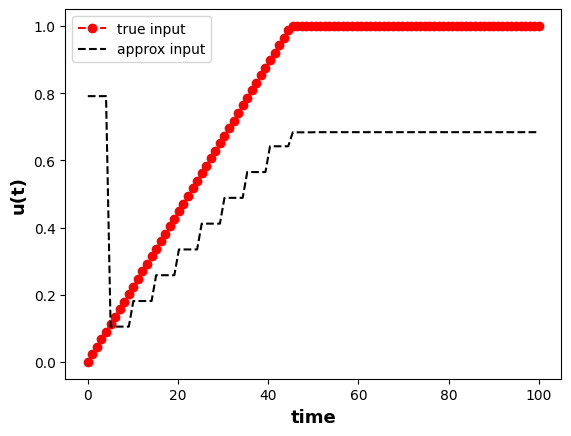

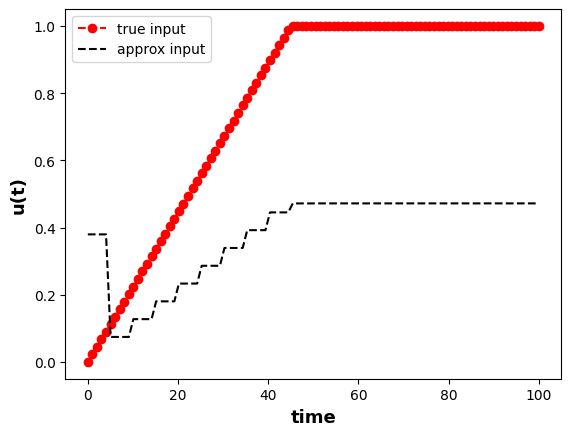

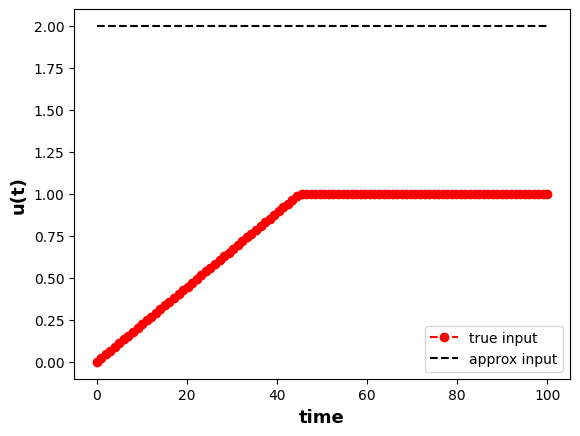

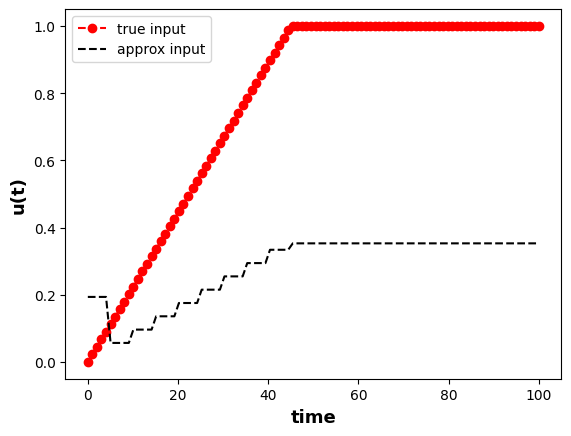

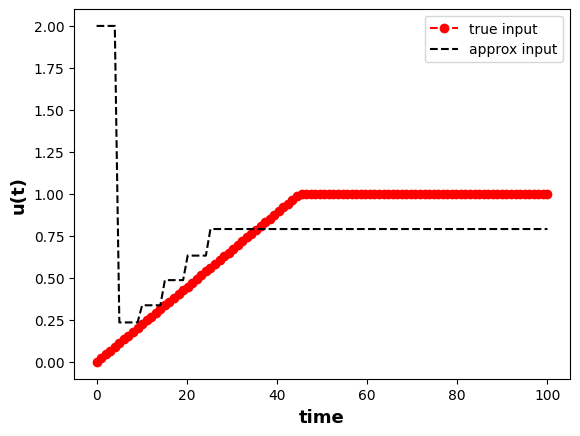

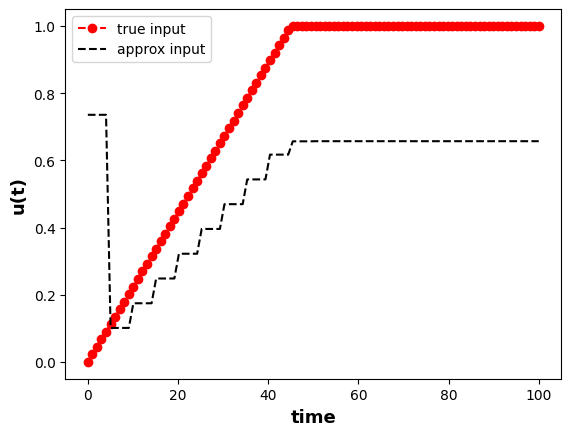

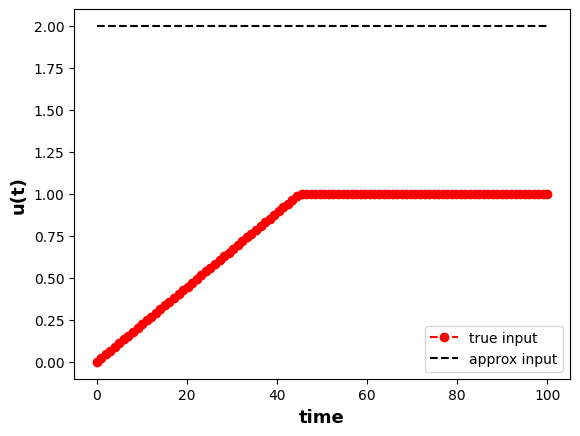

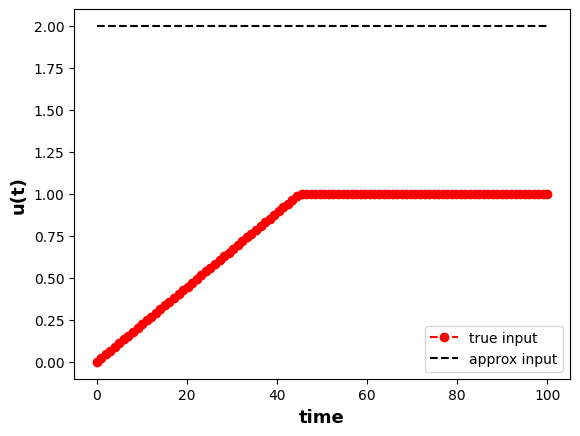

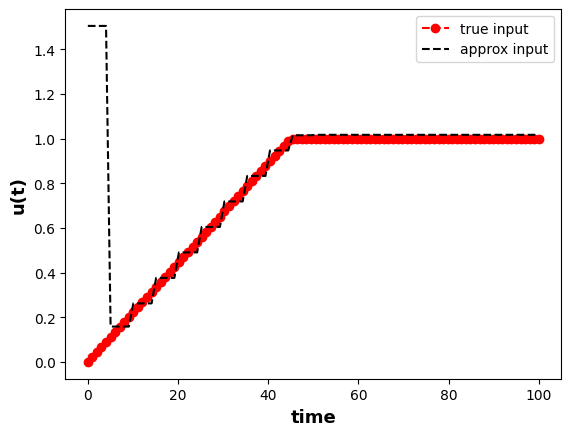

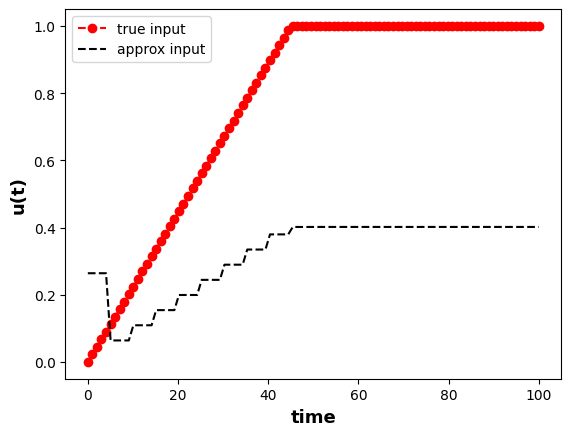

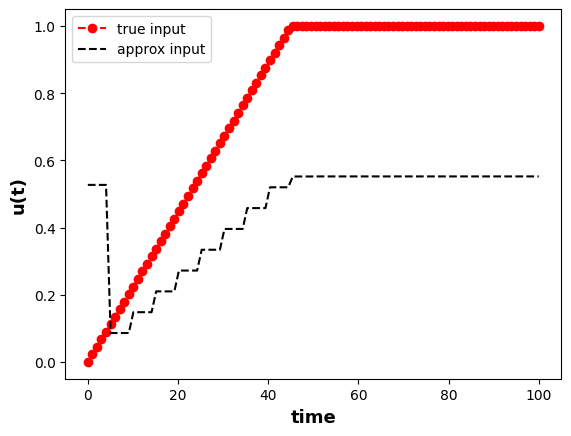

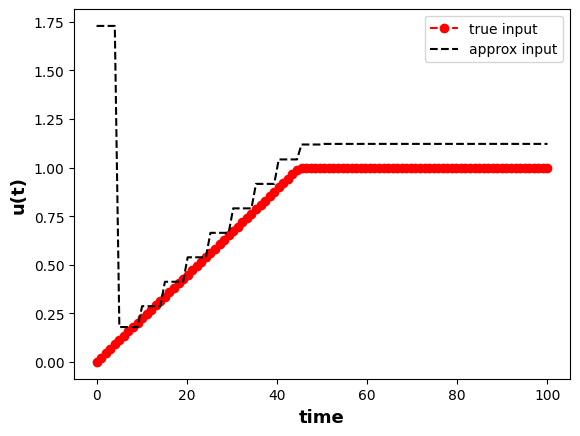

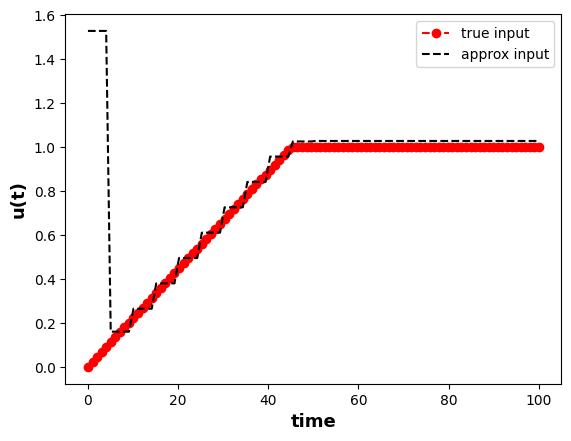

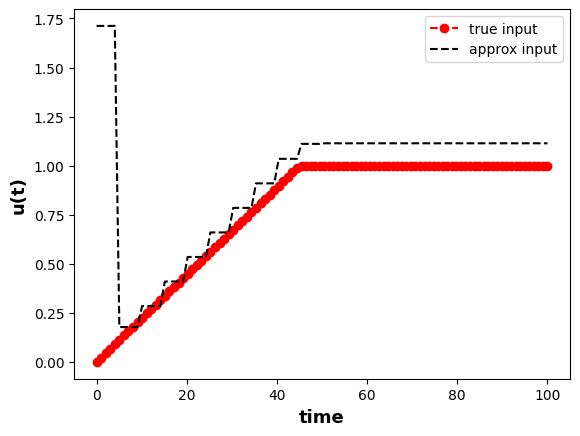

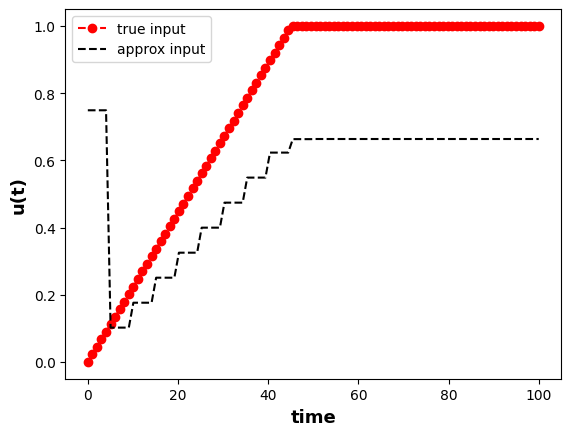

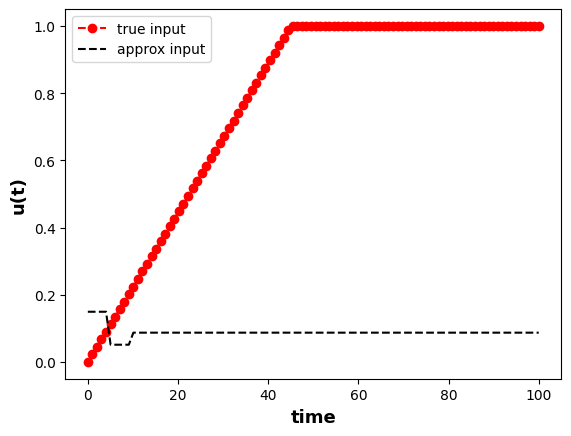

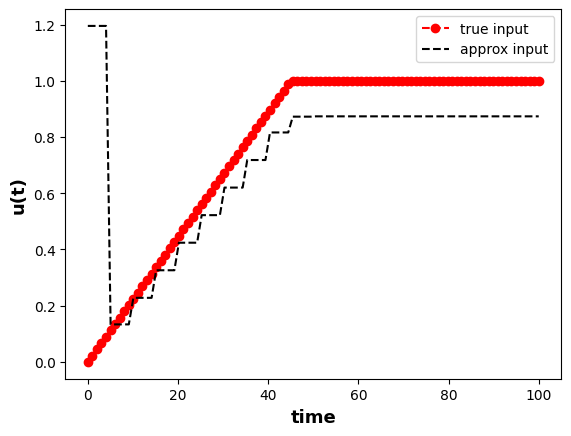

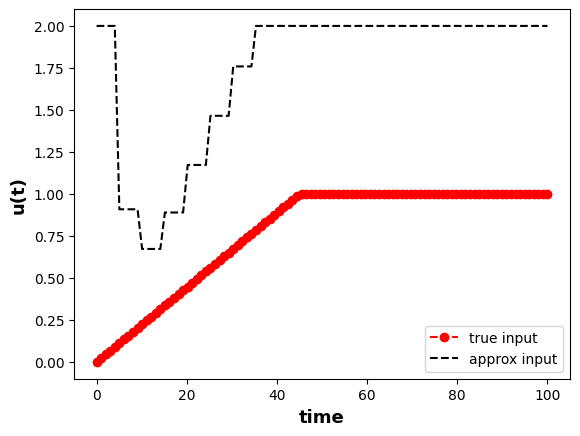

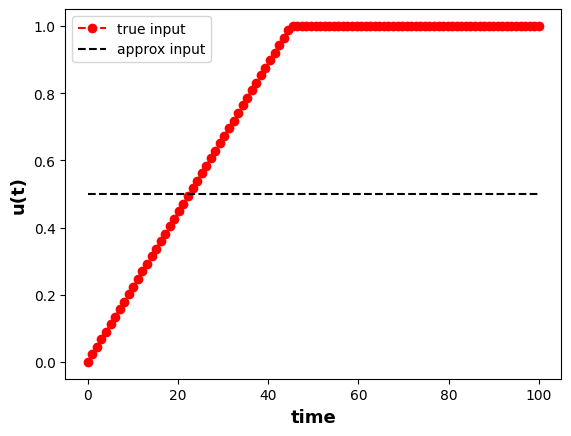

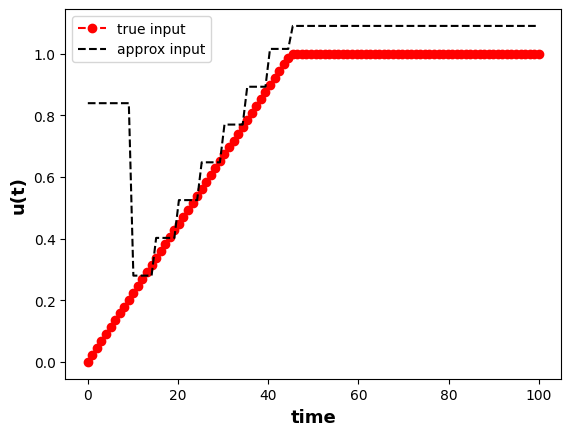

In [7]:
## runs the algorithm to fit parameter estimates 

num_time_pts = 100

param_err_runs = np.zeros((num_time_pts,))
approx_param_arr = np.zeros((num_time_pts,20))


# switch detection parameters
switch_gap = 1
ls_model = "ar"

# Sets initial parameter value guesses for first time domain 
#           [alpha, beta, bm,  bp]
params_init = [.5]

# set bounds for paramsin the form of : (lower, upper)
#         [alpha,    beta,     bm,     bp]
# bounds = [(0, 10), (0, 10), (1, 10), (1, 10)]
model_param_bounds = [(-2, 2)]

# static params must be the last params defined in
# pend and the objective function
num_static_params = 0

# run it 20 times to compare aggregate results
for i in range(20):

    # Gets simulated data
    # everytime sim() is ran, it generates noise for the mismatched model
    # and produces the data
    data , t = sim()

    # gets shape of data
    m,n = np.shape(data)

    # number of switches
    sigma=str(m//6)

    # true parameter time-seriess
    param_time_true = param3(t)


    result = cont_pw_tv_model_ID(data, t, switch_gap, 
                                 ls_model, 
                                 sigma, params_init,
                                 model_param_bounds, 
                                 num_static_params)
    
    param_time = result['param_time']
    num_switches = result['num_switches']
    time_intervals_dict = result['time_intervals_dict']
    traj_dict = result['traj_dict']
    traj = result['traj']
    param_matrix = result['param_matrix']
    num_time_intervals = result['num_time_intervals']
    params_dict = result['params_dict']
    err_array = result['err_array']

    approx_param_arr[:,i] = param_time['p0']

    param_err_runs[i] = rmse(param_time_true, param_time['p0'])

    ## plots trajectories
    # plt.figure(i)
    # plt.plot(t, data[:, 0], '--o', color = 'red', label='true x(t)')
    # plt.plot(t, data[:, 1], '--o', color = 'green', label='true y(t)')
    # plt.plot(t, traj[:, 0], '--', color='black', label='model reconst')
    # plt.plot(t, traj[:,1], '--', color='black')
    # plt.xlabel('time', fontsize=13, weight= 'bold')
    # plt.ylabel('x(t)', fontsize=13, weight= 'bold')
    # plt.legend(loc='best')

    ## plots parameters
    plt.figure(i)
    plt.plot(t, param_time_true, '--o', color = 'red', label='true input')
    plt.plot(t, param_time['p0'], '--', color='black', label='approx input')
    plt.xlabel('time', fontsize=13, weight= 'bold')
    plt.ylabel('u(t)', fontsize=13, weight= 'bold')
    plt.legend(loc='best')


    
        
# note that for troubleshooting, all of the results which are dictionaries have keys 
# which can be analyzed as below

# print(result.keys())


## Get stats and plot

In [8]:
param_mean_vector, param_std_vector, param_sem_vector, = get_stats(approx_param_arr)

print(np.mean(param_err_runs))


0.11271461150944038


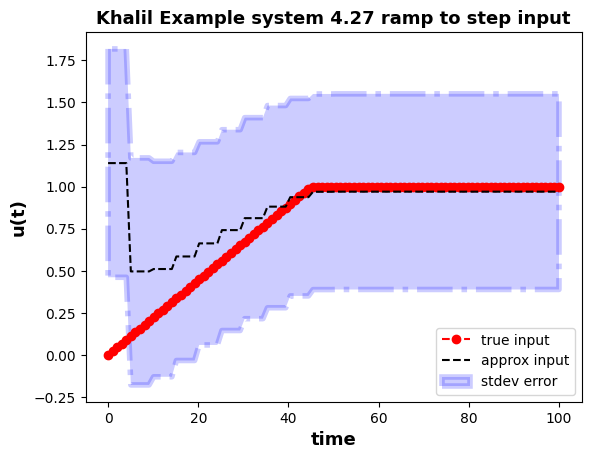

In [11]:
## plots parameters
plt.figure()
plt.plot(t, param_time_true, '--o', color = 'red', label='true input')
plt.plot(t, param_mean_vector, '--', color='black', label='approx input')
plt.fill_between(t, 
                 np.add(param_mean_vector, -param_std_vector), 
                 np.add(param_mean_vector, param_std_vector),
                 alpha=0.2, edgecolor='b', facecolor='b',
                 linewidth=4, linestyle='dashdot', label = 'stdev error', antialiased=True)
plt.xlabel('standard deviation', fontsize=13, weight= 'bold')
plt.ylabel('trajectory error', fontsize=13, weight= 'bold')
plt.xlabel('time', fontsize=13, weight= 'bold')
plt.ylabel('u(t)', fontsize=13, weight= 'bold')
plt.legend(loc='best')
plt.title('Khalil Example system 4.27 ramp to step input', fontsize=13, weight= 'bold')
plt.savefig(os.path.join(os.getcwd(), 'ramp_step_param.svg'), format='svg')
